In [1]:
import tensorflow
from tensorflow import keras
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os, cv2, random
import numpy as np
import pandas as pd

In [3]:
from matplotlib import ticker
import seaborn as sns

データの呼び込み・生成

In [4]:
TRAIN_DIR = "/Users/yukimura/Downloads/dogscats/train/"
TEST_DIR = "/Users/yukimura/Downloads/dogscats/test/"


In [5]:
ROWS = 64
COLS = 64
CHANNELS = 3

In [6]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]

In [7]:
train_dogs = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if "dog" in i]
train_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if "cat" in i]

In [8]:
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

train dataは全部読み込むと多すぎるので先頭の1000個を読み込む！

In [9]:
train_images = train_dogs[:1000] + train_cats[:1000]
len(train_images)

2000

In [10]:
# shuffleする
random.shuffle(train_images)

test dataは先頭の25個だけとりだす

In [11]:
test_images = test_images[:25]

画像ファイルを多次元配列に変換する！

In [12]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [13]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype = np.uint8)
    
    for i , image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print("Processed {} of {}".format(i, count))
            
    return data

In [14]:
train = prep_data(train_images)
test = prep_data(test_images)

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 25


In [15]:
train.shape

(2000, 3, 64, 64)

In [16]:
test.shape

(25, 3, 64, 64)

Generating the labels

In [17]:
labels = []
for i in train_images:
    if "dog." in i:
        labels.append(1)
    else:
        labels.append(0)

In [18]:
labels[:10]

[0, 0, 0, 0, 1, 0, 1, 1, 1, 1]

In [19]:
train_images[:10] # 一致を確認

['/Users/yukimura/Downloads/dogscats/train/cat.3176.jpg',
 '/Users/yukimura/Downloads/dogscats/train/cat.6755.jpg',
 '/Users/yukimura/Downloads/dogscats/train/cat.2334.jpg',
 '/Users/yukimura/Downloads/dogscats/train/cat.10179.jpg',
 '/Users/yukimura/Downloads/dogscats/train/dog.12193.jpg',
 '/Users/yukimura/Downloads/dogscats/train/cat.8624.jpg',
 '/Users/yukimura/Downloads/dogscats/train/dog.4788.jpg',
 '/Users/yukimura/Downloads/dogscats/train/dog.6377.jpg',
 '/Users/yukimura/Downloads/dogscats/train/dog.945.jpg',
 '/Users/yukimura/Downloads/dogscats/train/dog.11659.jpg']

Text(0.5, 1.0, 'Cats and Dogs')

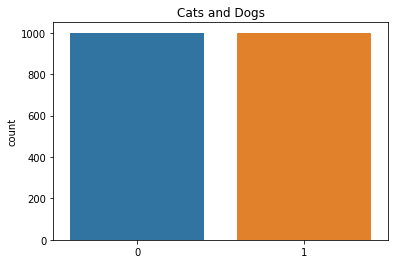

In [20]:
# seabornで可視化
sns.countplot(labels)
plt.title("Cats and Dogs")

画像データの確認

In [21]:
# 画像読み込み関数のdef
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis = 1)
    plt.figure(figsize = (10,5))
    plt.imshow(pair)
    plt.show()

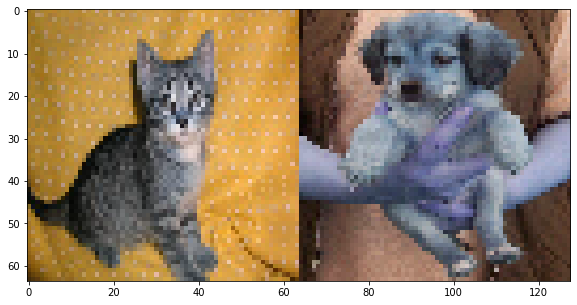

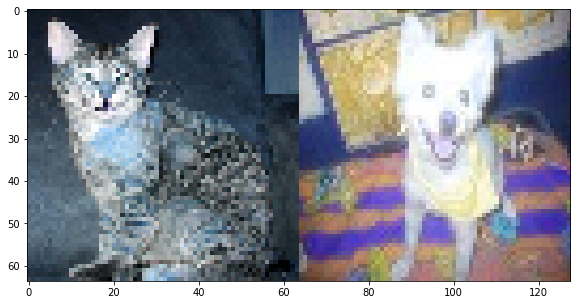

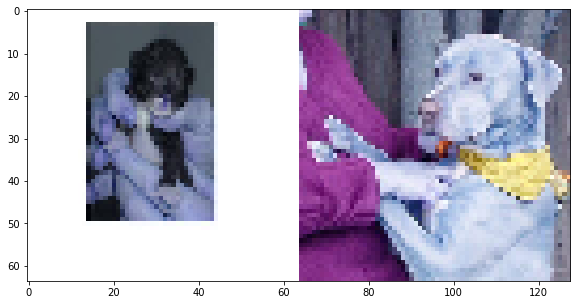

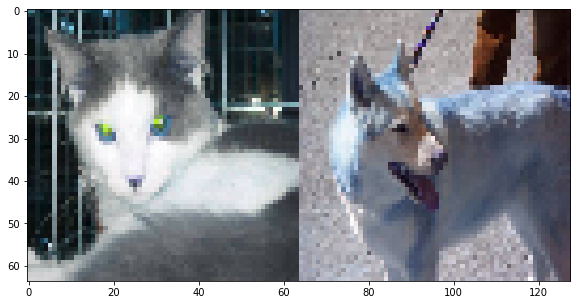

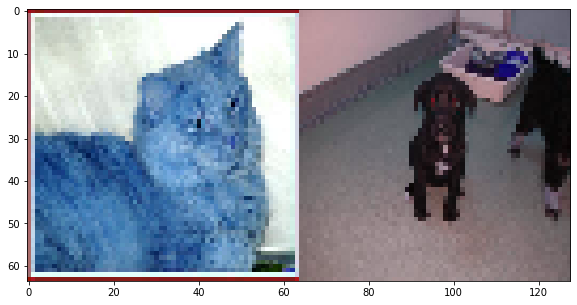

In [22]:
for idx in range(0,5):
    show_cats_and_dogs(idx)

# ピクセル値を平均して画像を生成する

Text(0.5, 1.0, 'Your Average Dog')

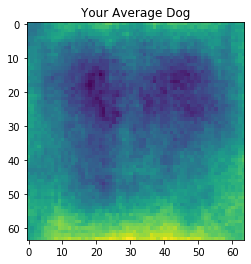

In [23]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i] == 1]).mean(axis = 0)
plt.imshow(dog_avg)
plt.title("Your Average Dog")

Text(0.5, 1.0, 'Your Average Cat')

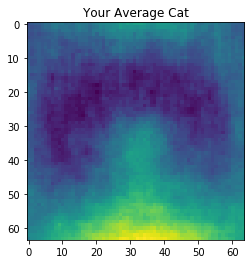

In [24]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i] == 0]).mean(axis = 0)
plt.imshow(cat_avg)
plt.title("Your Average Cat")

# いよいよモデルの定義をする！

## CatdogNet-16はVGG-16というNNをcompactにしたmodel
### 流れとしては、①4つのたたみ込みblock、②flat化、③2つの全結合層、④出力層は1node(Dog:1, Cat:0)
#### 最後はsigmoidで0-1の値を出力させる

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
# from tensorflow.keras.layers import Act
# from tensorflow.keras.utils import np_utils

In [31]:
optimizer = RMSprop(lr=1e-4)
objective = "binary_crossentropy"

def catdog():
    model = Sequential()
    
    model.add(Conv2D(32,(3,3),padding="same", input_shape = (3,ROWS,COLS), activation = "relu"))
    model.add(Conv2D(32,(3,3), padding = "same", activation = "relu"))
    model.add(MaxPooling2D(data_format = "channels_first", pool_size = (2,2)))
    
    model.add(Conv2D(64,(3,3), padding = "same", activation = "relu"))
    model.add(Conv2D(64,(3,3), padding = "same", activation = "relu"))
    model.add(MaxPooling2D(data_format = "channels_first", pool_size = (2,2)))
    
    model.add(Conv2D(128,(3,3), padding = "same", activation = "relu"))
    model.add(Conv2D(128,(3,3), padding = "same", activation = "relu"))
    model.add(MaxPooling2D(data_format = "channels_first", pool_size = (2,2)))
    
    model.add(Conv2D(256,(3,3), padding = "same", activation = "relu"))
    model.add(Conv2D(256,(3,3), padding = "same", activation = "relu"))
    model.add(MaxPooling2D(data_format = "channels_first", pool_size = (2,2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    
    model.compile(loss=objective, optimizer=optimizer, metrics=["accuracy"])
    return model

model = catdog()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
# 色々と修正してなんとかできた・・・

### トレーニングの実行

In [41]:
nb_epoch = 10 # 過学習なら減らす
batch_size = 16 # 大きいと学習が早くすすむ

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get("logs"))
        self.val_losses.append(logs.get("val_loss"))
        
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, verbose =1, mode = "auto")

In [42]:
def run_catdog():
    
    history = LossHistory() #　インスタンスの作成
    model.fit(train, labels, batch_size = batch_size,epochs=nb_epoch,
             validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    # validation_split 0.25とは学習に75%使い、25%で精度を評価という意味
    # verbose=0 は途中経過を表示しなくてよい
    # shuffle = Trueはmini batchの中でdataをshuffleするかどうか
    
    predictions = model.predict(test,verbose=0)
    return predictions, history



In [40]:
predictions, history = run_catdog()

InvalidArgumentError: input and filter must have the same depth: 32 vs 16
	 [[{{node conv2d_18/Relu}}]]